# Incremental Collaborative Filtering (ICF) implementation - Example of usage

An example of usage of the implementation of the algorithm Incremental Colalborative Filtering is presented in this notebook.
The dataset used is Movielens 100k, available in: https://maxhalford.github.io/files/datasets/ml_100k.zip . 
The dataset is also available along the compacted folder in which the project was sent as 'ml_100k.csv'.

Below, the necessary imports are made from our myICF package, namely:
- `stream`: generator utility used to simulate a data stream from tabular data. It expects a path to a csv file that contains columns 'user', 'item', and 'rating'.
- `myICF_helper`: inherits all methods from `myICF`, the class used to implement Incremental Collaborative Filtering algorithm by Papagelis et al. (2005). Given that movielens 100k is the dataset used in this project, this class also has utility functions to recover the title of movies, in order to present the recommendations as movie titles instead of movie IDs. If another dataset other than movielens is used, the parameter 'description_column', passed on instanciation, must be modified to accept a proper item description column instead of the 'title' column.

One could also import the class myICF directly by using `from myICF.main import myICF`.

In [1]:
from myICF.utils import stream, myICF_helper

We also import `matplotlib.pyplot` in order to create graphics later on.

In [2]:
import matplotlib.pyplot as plt

Next, the class `myICF_helper` is instanciated. 
If you intend to use it with other datasets, please do check the docstrings for guidance.

In [3]:
icf = myICF_helper(filepath='ml_100k.csv')

In the code block below the we implement prequential evaluation in the following form:
 - We create empty Python lists to accumulate hit rates.
 - The imported generator function `stream` is used to yield cases from the dataset, simulating a data stream.
     - The dataset must be a .csv file containing the colmuns user, item, and rating. Its path is passed to the parameter 'filepath'.
 - For every new observation, three lists of recommendations are made with 10, 50, and 100 recommendations (`icf.recommend`). If the new item just received is within the list of recommended items, the value 1 is appended to the respective list, otherwise the value 0 is appended.
 - Only after recording the hit rate the new observation is used to update the model with `icf.run`.
 - After recording the hit rate for 'max_cases' observations, the moving averages of the three hit rate lists are computed using a window of size 2500.
 - Finally, the moving averages of the hit rate lists over 10, 50, and 100 recommendations are plotted over the number of cases.

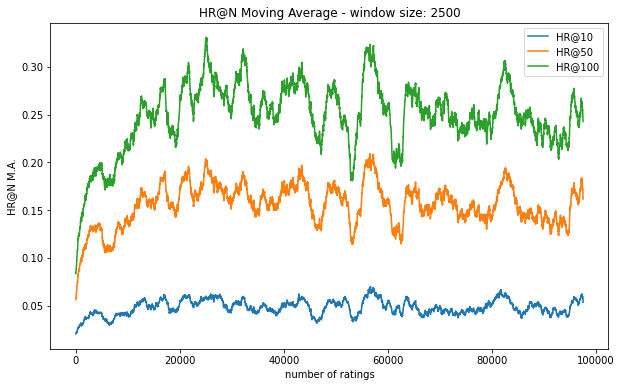

In [4]:
hit_rate_10 = []
hit_rate_50 = []
hit_rate_100 = []

for user, item, rating in stream(filepath='ml_100k.csv', delimiter='\t', max_cases=100000):
    try:
        if item in icf.recommend(user, n_recs=10):
            hit_rate_10.append(1)
        else:
            hit_rate_10.append(0)
            
        if item in icf.recommend(user, n_recs=50):
            hit_rate_50.append(1)
        else:
            hit_rate_50.append(0)
            
        if item in icf.recommend(user, n_recs=100):
            hit_rate_100.append(1)
        else:
            hit_rate_100.append(0)
    except:
        hit_rate_10.append(0)
        hit_rate_50.append(0)
        hit_rate_100.append(0)
        
    icf.run(user, item, rating)
    
mov_avg_rate = 2500
mov_avg_hr_10 = []
mov_avg_hr_50 = []
mov_avg_hr_100 = []
for i in range(len(hit_rate_10)):
    if (i+mov_avg_rate) == len(hit_rate_10):
        break
    mov_avg_hr_10.append(sum(hit_rate_10[i:i+mov_avg_rate])/mov_avg_rate)
    mov_avg_hr_50.append(sum(hit_rate_50[i:i+mov_avg_rate])/mov_avg_rate)
    mov_avg_hr_100.append(sum(hit_rate_100[i:i+mov_avg_rate])/mov_avg_rate)
    
plt.figure(figsize=(10,6))
plt.plot(range(len(mov_avg_hr_10)), mov_avg_hr_10, label='HR@10')
plt.plot(range(len(mov_avg_hr_50)), mov_avg_hr_50, label='HR@50')
plt.plot(range(len(mov_avg_hr_100)), mov_avg_hr_100, label='HR@100')
plt.title('HR@N Moving Average - window size: 2500')
plt.xlabel('number of ratings')
plt.ylabel('HR@N M.A.')
plt.legend()
plt.savefig(fname='hr_moving_avg.png');

Clearly, by recommending a greater number of items, the moving average of the hit rates are higher.
By using lists with 10 recommendations, the moving average of the hit rates stands overall near 5%.

## Example - show recommendations for user

Since the model has been trained in several other observations we can exemplify adding the ratings of a new user, Klismam, and making recommendations for him. 
We use the utility methods `user_favorites` and `show_recommended_titles` of the class `myICF_helper` to show the names of the movies that Klismam enjoyed, and to show the names of movies that are recommended to him, respectively.

Adding new user "Klismam, with rated movies:  

'Shining, The (1980)', 'Aliens (1986)', 'James and the Giant Peach (1996)', 'Seven (Se7en) (1995)', 'Pulp Fiction (1994)', 'Forrest Gump (1994)', 'Scream (1996)', 'Dead Poets Society (1989)', 'Star Wars (1977)', 'Jurassic Park (1993)'.

In [5]:
user = 'Klismam'
my_ratings = [
    (user, '200', 5), 
    (user, '176', 5),
    (user, '473', 5),
    (user, '50', 4), 
    (user, '82', 4), 
    (user, '11', 5),
    (user, '56', 5),
    (user, '69', 5),
    (user, '196', 5)   
]
for user, item, rating in my_ratings:
    icf.run(user, item, rating)

Showing the names of the movies Klismam rated.

In [6]:
icf.user_favorites(user, n_items=15)

['Shining, The (1980)',
 'Aliens (1986)',
 'James and the Giant Peach (1996)',
 'Seven (Se7en) (1995)',
 'Pulp Fiction (1994)',
 'Forrest Gump (1994)',
 'Dead Poets Society (1989)',
 'Star Wars (1977)',
 'Jurassic Park (1993)']

Showing 15 recommendations for Klismam.

In [7]:
icf.show_recommended_titles(user, n_items=15)

['Fargo (1996)',
 'Godfather, The (1972)',
 "One Flew Over the Cuckoo's Nest (1975)",
 'English Patient, The (1996)',
 'Silence of the Lambs, The (1991)',
 'Dead Man Walking (1995)',
 'Sense and Sensibility (1995)',
 'When Harry Met Sally... (1989)',
 'Shawshank Redemption, The (1994)',
 "Schindler's List (1993)",
 'Postino, Il (1994)',
 'Casablanca (1942)',
 'Contact (1997)',
 'Secrets & Lies (1996)',
 'Graduate, The (1967)']

To show the IDs along the descriptions of all items in the dataset, we can use the utility method `get_titles`.

In [8]:
icf.get_titles()

{'255': "My Best Friend's Wedding (1997)",
 '286': 'English Patient, The (1996)',
 '298': 'Face/Off (1997)',
 '185': 'Psycho (1960)',
 '173': 'Princess Bride, The (1987)',
 '108': 'Kids in the Hall: Brain Candy (1996)',
 '772': 'Kids (1995)',
 '288': 'Scream (1996)',
 '928': 'Craft, The (1996)',
 '117': 'Rock, The (1996)',
 '200': 'Shining, The (1980)',
 '405': 'Mission: Impossible (1996)',
 '1074': 'Reality Bites (1994)',
 '176': 'Aliens (1986)',
 '357': "One Flew Over the Cuckoo's Nest (1975)",
 '210': 'Indiana Jones and the Last Crusade (1989)',
 '687': "McHale's Navy (1997)",
 '696': 'City Hall (1996)',
 '284': 'Tin Cup (1996)',
 '295': 'Breakdown (1997)',
 '473': 'James and the Giant Peach (1996)',
 '544': "Things to Do in Denver when You're Dead (1995)",
 '290': 'Fierce Creatures (1997)',
 '147': 'Long Kiss Goodnight, The (1996)',
 '121': 'Independence Day (ID4) (1996)',
 '717': 'Juror, The (1996)',
 '220': 'Mirror Has Two Faces, The (1996)',
 '1040': 'Two if by Sea (1996)',
 '51